<a href="https://colab.research.google.com/github/rahakaushik/quant_finance/blob/main/pair_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install statsmodels

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
def get_stock_data(ticker, start_date, end_date):
    stock = yf.download(ticker, start=start_date, end=end_date)
    return stock['Close']

In [4]:
def calculate_spread(stock1, stock2):
    stock1 = sm.add_constant(stock1)
    model = sm.OLS(stock2, stock1).fit()
    hedge_ratio = model.params[1]
    spread = stock2 - hedge_ratio * stock1.iloc[:, 1]
    return spread, hedge_ratio

In [5]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [6]:
def trade_pairs_old(stock1_prices, stock2_prices, entry_threshold=2.0, exit_threshold=0.5):
    spread, hedge_ratio = calculate_spread(stock1_prices, stock2_prices)
    spread_zscore = zscore(spread)

    signals = pd.DataFrame(index=spread.index)
    signals['Stock1 Position'] = 0
    signals['Stock2 Position'] = 0

    signals['Stock1 Position'][spread_zscore > entry_threshold] = -1  # Short Stock1
    signals['Stock2 Position'][spread_zscore > entry_threshold] = 1   # Long Stock2

    signals['Stock1 Position'][spread_zscore < -entry_threshold] = 1  # Long Stock1
    signals['Stock2 Position'][spread_zscore < -entry_threshold] = -1 # Short Stock2

    signals['Stock1 Position'][abs(spread_zscore) < exit_threshold] = 0
    signals['Stock2 Position'][abs(spread_zscore) < exit_threshold] = 0

    return signals, spread, spread_zscore

In [7]:
def trade_pairs(stock1_prices, stock2_prices, entry_threshold=2.0, exit_threshold=0.5):
    spread, hedge_ratio = calculate_spread(stock1_prices, stock2_prices)
    spread_zscore = zscore(spread)

    signals = pd.DataFrame(index=spread.index)
    signals['Stock1 Position'] = 0
    signals['Stock2 Position'] = 0

    # Use .loc with boolean indexing to ensure alignment of indices
    signals.loc[spread_zscore[spread_zscore > entry_threshold].index, 'Stock1 Position'] = -1  # Short Stock1
    signals.loc[spread_zscore[spread_zscore > entry_threshold].index, 'Stock2 Position'] = 1   # Long Stock2

    signals.loc[spread_zscore[spread_zscore < -entry_threshold].index, 'Stock1 Position'] = 1  # Long Stock1
    signals.loc[spread_zscore[spread_zscore < -entry_threshold].index, 'Stock2 Position'] = -1 # Short Stock2

    signals.loc[spread_zscore[abs(spread_zscore) < exit_threshold].index, 'Stock1 Position'] = 0
    signals.loc[spread_zscore[abs(spread_zscore) < exit_threshold].index, 'Stock2 Position'] = 0

    return signals, spread, spread_zscore

In [8]:
def backtest(signals, stock1_prices, stock2_prices):
    """ Calculate strategy returns based on generated signals """
    positions = signals.shift(1)  # Avoid lookahead bias

    stock1_returns = stock1_prices.pct_change().fillna(0)
    stock2_returns = stock2_prices.pct_change().fillna(0)

    strategy_returns = (positions['Stock1 Position'] * stock1_returns) + \
                       (positions['Stock2 Position'] * stock2_returns)

    cumulative_returns = (1 + strategy_returns).cumprod()

    return cumulative_returns, strategy_returns


In [9]:
stock1_ticker = 'AAPL'
stock2_ticker = 'MSFT'
start_date = '2024-01-01'
end_date = '2025-01-01'

# Fetch data
stock1_prices = get_stock_data(stock1_ticker, start_date, end_date)
stock2_prices = get_stock_data(stock2_ticker, start_date, end_date)

# Run trading strategy
signals, spread, spread_zscore = trade_pairs(stock1_prices, stock2_prices)

# Run Backtest
cumulative_returns, strategy_returns = backtest(signals, stock1_prices, stock2_prices)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-4-5f1ccd936d3c>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


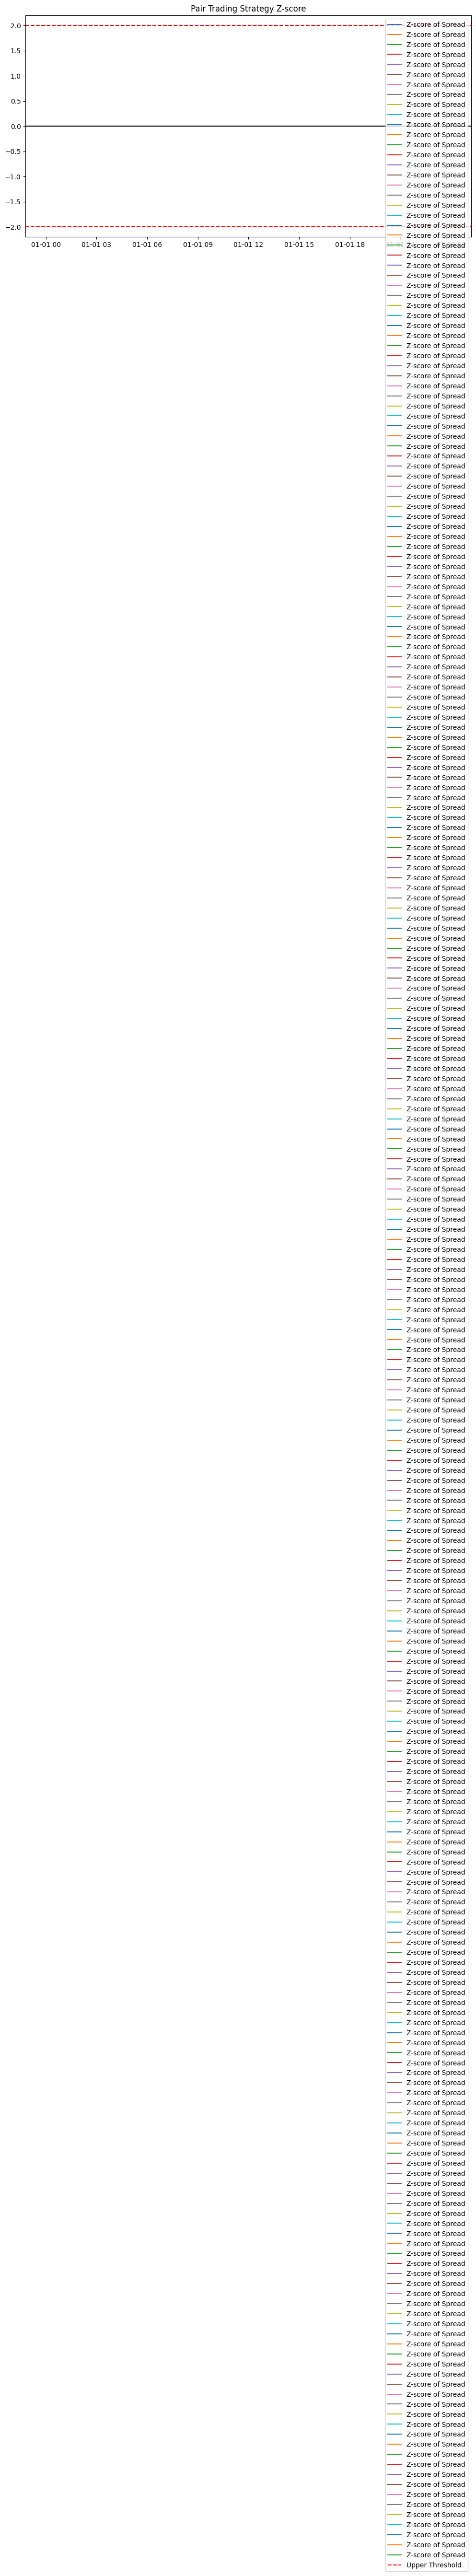

In [ ]:
# Plot Z-score
plt.figure(figsize=(12,6))
plt.plot(spread_zscore, label='Z-score of Spread')
plt.axhline(2.0, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(-2.0, color='r', linestyle='--')
plt.axhline(0, color='k', linestyle='-')
plt.title('Pair Trading Strategy Z-score')
plt.legend()
plt.show()

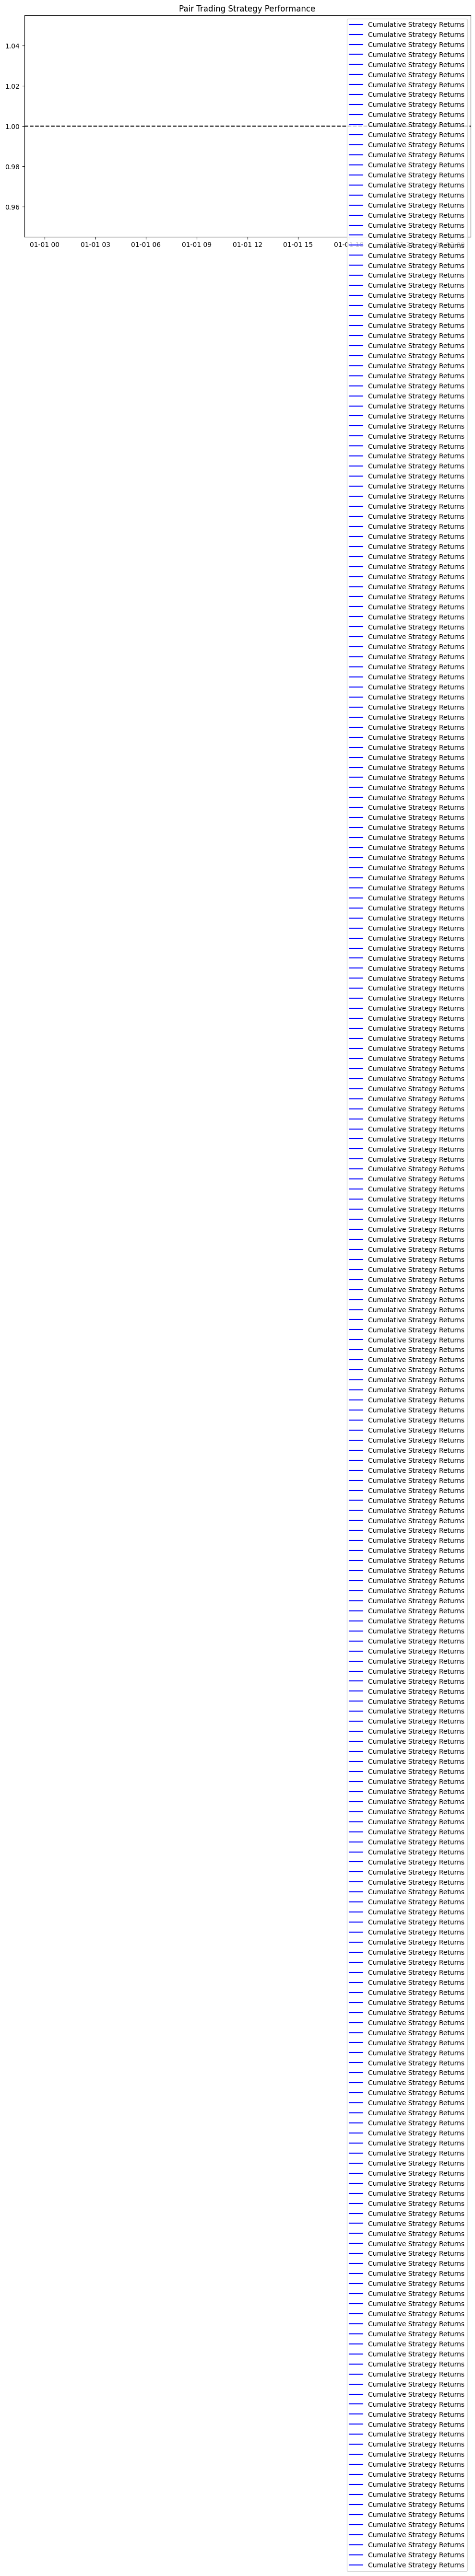

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label="Cumulative Strategy Returns", color='b')
plt.axhline(1, color='k', linestyle='--')
plt.title("Pair Trading Strategy Performance")
plt.legend()
plt.show()